In [2]:
# import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.model_selection import ParameterGrid


In [3]:
clean_data = pd.read_csv('new_df_womissing.csv')
clean_data

,Unnamed: 0,Account No,Balance,Amount,Third Party Account No,Third Party Name,DateTime
0,0,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,2023-01-01 00:00:00
1,1,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,2023-01-01 00:00:00
2,2,472213568.0,3012.000000,-780.00,283027736.0,NaN,2023-01-01 00:00:00
3,3,283027736.0,1787.000000,780.00,472213568.0,NaN,2023-01-01 00:00:00
4,4,624500124.0,3226.000000,1825.00,NaN,Fat Face,2023-01-01 00:00:00
...,...,...,...,...,...,...,...
230121,230121,581655972.0,45935.206861,-41.06,NaN,Tesco,2023-12-06 20:54:00
230122,230122,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,2023-12-06 20:55:00
230123,230123,824916823.0,9709.172159,-32.94,NaN,Deliveroo,2023-12-06 21:05:00
230124,230124,366550080.0,26834.165794,-19.25,NaN,Amazon,2023-12-06 21:13:00


In [4]:
clean_data.isnull().sum()

Unnamed: 0                     0
Account No                     0
Balance                        0
Amount                         0
Third Party Account No    223297
Third Party Name            6829
DateTime                       0
dtype: int64

In [5]:
clean_data = clean_data.drop(['Unnamed: 0', 'Third Party Account No'], axis=1)

In [6]:
data = clean_data.dropna()
data

,Account No,Balance,Amount,Third Party Name,DateTime
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00
...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00


In [9]:
df = pd.DataFrame(data)

zero_amount_df = df[df['Amount'] == 0]

zero_amount_df

,Account No,Balance,Amount,Third Party Name,DateTime
124060,950234174.0,776.302067,-0.0,Selfridges,2023-07-11 08:21:00
132525,738958551.0,5564.249325,-0.0,Amazon,2023-07-29 18:32:00
134237,730002588.0,12939.954627,-0.0,Fat Face,2023-07-31 17:42:00
146674,581655972.0,34362.247639,-0.0,Fitted Stitch,2023-08-15 05:45:00
168782,322221939.0,3186.856806,-0.0,Revella,2023-09-16 08:04:00
192920,912705941.0,17527.347189,-0.0,Tesco,2023-10-21 05:41:00
197774,520447032.0,7416.909870,-0.0,Lloyds Pharmacy,2023-10-30 09:22:00
212971,824916823.0,8591.033140,-0.0,Sainsbury Local,2023-11-16 05:47:00
219931,687135796.0,28698.757249,-0.0,Sainsbury,2023-11-29 07:29:00


In [10]:
df

,Account No,Balance,Amount,Third Party Name,DateTime
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00
...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00


In [11]:
data['Third Party Name'].unique()

array(['Westport Care Home', 'Barbiee Boutique', 'Fat Face',
       'Lavender Primary', 'A Cut Above', 'Tesco', 'Brilliant Brushes',
       'Costa Coffee', 'Premier Finance', 'North Face', 'Craftastic',
       'Fitted Stitch', 'Selfridges', 'Starbucks', 'The Crown',
       'Cass Art', 'Green Park Academy', 'Rose & Crown', 'Kings Arms',
       'Sunny Care Nursery', 'A Yarn Story', 'Pets Corner',
       'Lavender Fields', 'Victoria Park', 'Halifax', 'LBG', 'Blizzard',
       'Xbox', 'Mojang Studios', 'PureGym', 'Disney', 'Netflix',
       'Grand Union BJJ', 'Amazon', 'SquareOnix', 'Deliveroo', 'JustEat',
       'Coop Local', 'Sainsbury', 'AMAZON', 'The Works', "Blackwell's",
       'Topshop', 'Matalan', 'Foyles', 'Wool', 'Hobby Lobby', 'Revella',
       'Sainsbury Local', 'Loosely Fitted', 'Stitch By Stitch',
       'Coffee #1', 'Hobbycraft', 'Lloyds Pharmacy', 'Gamestation', 'CeX',
       'Etsy', 'Five Senses Art', 'Sports Direct', 'Boots', 'Reebok',
       'JD Sports', 'Head', 'Frankie

In [12]:
holiday_data = {
    'date': ['2025-01-01', '2025-04-18', '2025-12-25', '2025-12-26', '2025-04-18', '2025-04-21', '2025-05-05', '2025-05-26', '2025-08-25'],
    'holiday': ['New Year\'s Day', 'Good Friday', 'Christmas Day', 'Boxing Day', 'Good Friday', 'Easter Monday', 'Early May bank holiday', 'Spring bank holiday', 'Summer bank holiday']
}
df_holidays = pd.DataFrame(holiday_data)
df_holidays

,date,holiday
0,2025-01-01,New Year's Day
1,2025-04-18,Good Friday
2,2025-12-25,Christmas Day
3,2025-12-26,Boxing Day
4,2025-04-18,Good Friday
5,2025-04-21,Easter Monday
6,2025-05-05,Early May bank holiday
7,2025-05-26,Spring bank holiday
8,2025-08-25,Summer bank holiday


In [13]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'])
df_holidays['month_day'] = df_holidays['date'].dt.strftime('%m-%d')

data['DateTime'] = pd.to_datetime(data['DateTime'])
data['month_day'] = data['DateTime'].dt.strftime('%m-%d')

df_holidays = df_holidays.drop_duplicates(subset=['month_day'])

data['Holiday'] = data['month_day'].map(df_holidays.set_index('month_day')['holiday'])

data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,New Year's Day
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,New Year's Day
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,New Year's Day
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,New Year's Day
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,New Year's Day
...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,NaN
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,NaN
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,NaN
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,NaN


In [14]:
data.fillna(False)

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,New Year's Day
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,New Year's Day
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,New Year's Day
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,New Year's Day
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,New Year's Day
...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False


In [15]:
def check_holiday(holiday):
    if isinstance(holiday, str):
        return True
    else:
        return False

# Apply the function to the 'Holiday' column
data['Holiday'] = data['Holiday'].apply(check_holiday)

data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,True
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,True
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,True
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,True
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,True
...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False


In [16]:
data

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,True
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,True
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,True
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,True
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,True
...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False


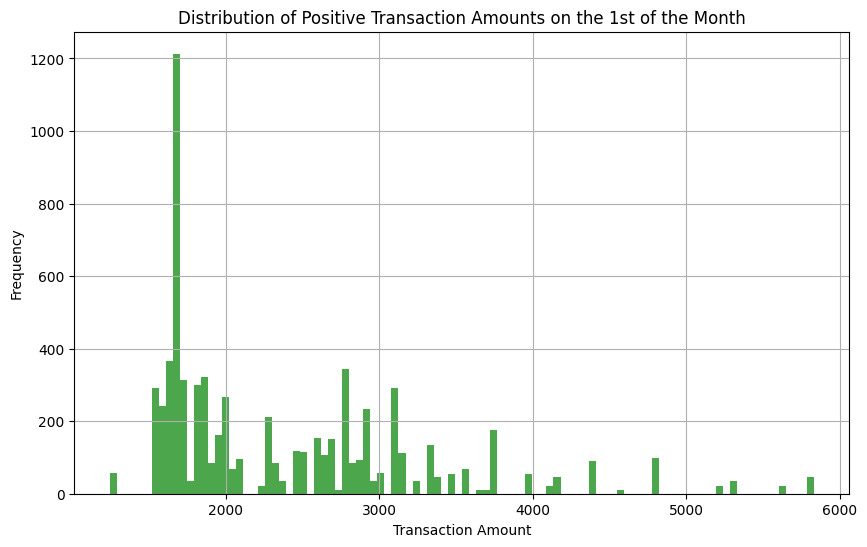

2300.0

In [17]:
# filter to consider only positive transaction amounts on the 1st as it potential to be salary
positive_transactions_on_first = data[data['Amount'] > 0]

# plot the distribution of positive transaction amounts on the 1st
plt.figure(figsize=(10, 6))
plt.hist(positive_transactions_on_first['Amount'], bins=100, color='green', alpha=0.7)
plt.title('Distribution of Positive Transaction Amounts on the 1st of the Month')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# calculate the 58th percentile of positive transaction amounts on the 1st as a potential threshold for salary identification
positive_threshold = positive_transactions_on_first['Amount'].quantile(0.58) # from graph of Don said 28,400 is med of income so i devined it into 12
positive_threshold


In [18]:
# filer data for transactions on the 1st day that are above the threshold
potential_salaries = data[(data['DateTime'].dt.day == 1) & (data['Amount'] > positive_threshold)]

# group by account and month to see if these transactions occur consistently
salary_by_account = potential_salaries.groupby('Account No').apply(lambda x: x['DateTime'].dt.month.unique())

consistent_salary_accounts = salary_by_account[salary_by_account.apply(len) >= 3]  # cutoff of at least 3 months

consistent_salary_accounts.head(), len(consistent_salary_accounts)


(Account No
 124125096.0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 131388684.0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 137822385.0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 147474476.0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 151968462.0    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
 dtype: object,
 96)

In [19]:
# Correct the function to access the day attribute directly from the Timestamp object
salary_account_numbers = set(consistent_salary_accounts.index)
def flag_salary(row):
    if (row['Account No'] in salary_account_numbers) and (row['DateTime'].day == 1) and (row['Amount'] > positive_threshold):
        return True
    return False

# Apply the function to create the Is_Salary column
data['Is_Salary'] = data.apply(flag_salary, axis=1)

# Check results - displaying some flagged as True and some as False
data[['Account No', 'DateTime', 'Amount', 'Is_Salary']].head(10), data[['Account No', 'DateTime', 'Amount', 'Is_Salary']].tail(10)




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(     Account No   DateTime   Amount  Is_Salary
 0   678330503.0 2023-01-01  1584.00      False
 1   472213568.0 2023-01-01  1950.00      False
 4   624500124.0 2023-01-01  1825.00      False
 5   203466392.0 2023-01-01  2841.66       True
 6   768271776.0 2023-01-01  1950.00      False
 9   456221621.0 2023-01-01  1675.00      False
 10  350921975.0 2023-01-01  1842.50      False
 12  455831435.0 2023-01-01  1620.10      False
 15  832564361.0 2023-01-01  3542.00       True
 16  407574996.0 2023-01-01  1609.00      False,
          Account No            DateTime  Amount  Is_Salary
 230116  166019891.0 2023-12-06 20:39:00  -62.47      False
 230117  975345315.0 2023-12-06 20:40:00  -73.71      False
 230118  106601471.0 2023-12-06 20:43:00  -37.25      False
 230119  522188082.0 2023-12-06 20:48:00  -17.05      False
 230120  256002321.0 2023-12-06 20:50:00  -24.80      False
 230121  581655972.0 2023-12-06 20:54:00  -41.06      False
 230122  786141370.0 2023-12-06 20:55:00  -62.35   

In [20]:
data['Is_Salary'].sum()

1152

In [21]:
data

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,True,False
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,True,False
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,True,False
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,True,True
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,True,False
...,...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False,False


In [22]:
# # drop the original 'DateTime' column
# data = data.drop(['DateTime'], axis=1)

# X = data.drop(['Account No'], axis=1)
# X



# With flag column

In [20]:
# X = data.drop(['month_day'], axis=1)
# X


In [21]:
# X = X.drop(['Account No'], axis=1)
# X

In [22]:
# data['Account No'].unique.sum()

In [23]:
# RANDOM_STATE = 10
# column_transformer = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(handle_unknown='ignore'), ['Third Party Name']),
#         ('scaler', StandardScaler(), ['Balance', 'Amount'])
#     ],
#     remainder='passthrough'
# )


# X_preprocessed = column_transformer.fit_transform(X)

# X_train, X_val = train_test_split(X_preprocessed, test_size=0.2, random_state=RANDOM_STATE)

# # One-Class SVM parem
# param_grid = {
#     'nu': [0.01, 0.05, 0.1],
#     'kernel': ['rbf', 'poly', 'sigmoid'],
#     'gamma': ['auto', 'scale']
# }

# # find bes param
# best_score = np.inf
# best_params = None

# for g in ParameterGrid(param_grid):
#     model = OneClassSVM(**g)
#     model.fit(X_train)
#     scores = model.decision_function(X_val)
#     score = -scores.mean()
#     if score < best_score:
#         best_score = score
#         best_params = g

# print("Best parameters:", best_params)

# oc_svm_best = OneClassSVM(**best_params)


In [24]:
# oc_svm_best.fit(X_preprocessed)

# anomaly_scores = oc_svm_best.decision_function(X_preprocessed)


In [25]:
# anomaly_scores

In [26]:
# anomaly_scores_df = pd.DataFrame(anomaly_scores, columns=['Anomaly Score'])

# data.reset_index(drop=True, inplace=True)

# # concatenate the anomaly scores with the original data
# data_with_scores = pd.concat([data, anomaly_scores_df], axis=1)

# print(data_with_scores.head())

In [27]:
# neg = data_with_scores[data_with_scores['Anomaly Score'] < 0]
# neg


In [28]:
# data_with_scores[data_with_scores['Anomaly Score'] >= 0]


In [29]:
# plt.hist(data_with_scores['Anomaly Score'], bins=50)
# plt.title('Distribution of Anomaly Scores')
# plt.xlabel('Anomaly Score')
# plt.ylabel('Frequency')
# plt.show()


In [30]:
# # find threshold of anomaly scores
# threshold = np.percentile(anomaly_scores, 1)
# threshold


In [31]:
# # use threshold to identifind the anomaly behavior
# data_with_scores['Is_Anomaly'] = anomaly_scores < threshold

# data_with_scores


In [32]:
# neg[neg['Account No']==472213568.0]

In [33]:
# neg[neg['Account No']==581655972.0]

In [34]:
# data_with_scores

In [35]:
# # show stats of 'Third Party Name'
# transaction_stats = data_with_scores.groupby('Account No').agg({
#     'Amount': ['mean', 'std', 'count', 'sum'],
#     'Anomaly Score': ['mean', 'min', 'max']
# }).reset_index()

# transaction_stats


In [36]:
# # identify the rik of 'Anomaly Score'
# transaction_stats['Risk Score'] = -transaction_stats['Anomaly Score', 'mean']
# transaction_stats['Medium Score']  = -transaction_stats['Anomaly Score', 'mean']
# transaction_stats['Low Score']  = -transaction_stats['Anomaly Score', 'mean']


# risk_threshold = transaction_stats['Risk Score'].quantile(0.95)
# risk_threshold_2 = transaction_stats['Risk Score'].quantile(0.1)

# transaction_stats['Is_High_Risk'] = transaction_stats['Risk Score'] > risk_threshold
# transaction_stats['Is_Medium_Risk'] = ((transaction_stats['Medium Score'] < risk_threshold) & (transaction_stats['Medium Score'] > risk_threshold_2))
# transaction_stats['Is_Low_Risk'] = transaction_stats['Low Score'] < risk_threshold_2

# high_risk_accounts = transaction_stats[transaction_stats['Is_High_Risk']]
# high_risk_accounts


In [37]:
# high_risk_accounts.shape

# Another Method

In [38]:
# clean_data = pd.read_csv('new_df_womissing.csv')
# clean_data

In [39]:
# clean_data = clean_data.drop(['Unnamed: 0'], axis=1)
# clean_data

In [40]:
# clean_data['Third Party Name'] = clean_data['Third Party Name'].fillna(clean_data['Third Party Account No'])
# clean_data

In [41]:
# clean_data = clean_data.drop(['Third Party Account No'], axis=1)
# clean_data

In [42]:
# clean_data[clean_data['Balance'] <0]

Why 38515 rows in balance is less than zero

In [43]:
# mean_amount = clean_data['Amount'].mean()
# std_amount = clean_data['Amount'].std()

# # 1. create 'anomaly' column
# lower_threshold = mean_amount - 3 * std_amount
# upper_threshold = mean_amount + 3 * std_amount

# # create 'anomaly' column
# clean_data['anomaly'] = (clean_data['Amount'] < lower_threshold) | (clean_data['Amount'] > upper_threshold)

# # 2. create 'potential fraud' column
# clean_data['potential fraud'] = (clean_data['Amount'] < -1000) & (clean_data['Balance'] < 10)

# # 3. create 'Reject transaction' column
# clean_data['Reject transaction'] = clean_data['Amount'] == 0

# clean_data

In [44]:
# clean_data[clean_data['anomaly'] == True].count()

In [45]:
# clean_data[clean_data['anomaly'] == True]

In [46]:
# clean_data[clean_data['potential fraud'] == True]

In [47]:
# clean_data[clean_data['Reject transaction'] == True]

In [48]:
# df_holidays['date'] = pd.to_datetime(df_holidays['date'])
# df_holidays['month_day'] = df_holidays['date'].dt.strftime('%m-%d')

# clean_data['DateTime'] = pd.to_datetime(data['DateTime'])
# clean_data['month_day'] = clean_data['DateTime'].dt.strftime('%m-%d')

# df_holidays = df_holidays.drop_duplicates(subset=['month_day'])

# clean_data['Holiday'] = clean_data['month_day'].map(df_holidays.set_index('month_day')['holiday'])

# clean_data

In [49]:
# clean_data.fillna(False)
# def check_holiday(holiday):
#     if isinstance(holiday, str):
#         return True
#     else:
#         return False

# # apply the function to the 'Holiday' column
# clean_data['Holiday'] = clean_data['Holiday'].apply(check_holiday)

# clean_data

In [50]:
# clean_data = clean_data.drop(columns='month_day')
# clean_data

In [51]:
# df = clean_data[clean_data['Account No'] == 734161378.0]
# df.to_csv('fraud_test.csv')
# df

In [52]:
# df = clean_data[(clean_data['Account No'] == 734161378.0) & (clean_data['Balance'] < 0)]


# Seperate Private and Business Transfer

In [23]:
data

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,True,False
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,True,False
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,True,False
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,True,True
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,True,False
...,...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False,False


In [24]:
mean_amount = data['Amount'].mean()
std_amount = data['Amount'].std()

# 1. create 'anomaly' column
lower_threshold = mean_amount - 3 * std_amount
upper_threshold = mean_amount + 3 * std_amount

# create 'anomaly' column
data['anomaly'] = (data['Amount'] < lower_threshold) | (data['Amount'] > upper_threshold)

# 2. create 'potential fraud' column
data['potential fraud'] = (data['Amount'] < -1000) & (data['Balance'] < 10)

# 3. create 'Reject transaction' column
data['Reject transaction'] = (data['Amount'] == 0)

data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,True,False,True,False,False
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,True,False,True,False,False
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,True,False,True,False,False
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,True,True,True,False,False
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False,False,False,False,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False,False,False,False,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False,False,False,False,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False,False,False,False,False


In [25]:
potential = data[data['potential fraud'] == True]
potential.to_csv('potential.csv')
potential

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction
507,172084472.0,-147.000000,-1296.0,LBG,2023-01-01,01-01,True,False,False,True,False
508,550169791.0,-281.000000,-1164.0,Halifax,2023-01-01,01-01,True,False,False,True,False
509,141521177.0,-464.000000,-1090.0,Halifax,2023-01-01,01-01,True,False,False,True,False
528,478986718.0,-692.000000,-1278.0,Halifax,2023-01-01,01-01,True,False,False,True,False
566,462962606.0,-388.000000,-1049.0,Halifax,2023-01-01,01-01,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
222516,321372947.0,-161.454951,-1262.0,Halifax,2023-12-01,12-01,False,False,False,True,False
222526,610450243.0,-197.109600,-1081.0,LBG,2023-12-01,12-01,False,False,False,True,False
222527,596463612.0,-1955.512605,-1012.0,Halifax,2023-12-01,12-01,False,False,False,True,False
222533,162370388.0,-2494.850400,-1286.0,LBG,2023-12-01,12-01,False,False,False,True,False


In [26]:
data['potential fraud wo concerning Balance'] = (data['Amount'] < -500)
data



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,True,True,True,False,False,False
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False,False,False,False,False,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False,False,False,False,False,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False,False,False,False,False,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False,False,False,False,False,False


In [40]:
data[(data['Holiday'] ==False)& (data['Is_Salary']==False)&(data['anomaly']==True)]


,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance
20194,641764023.0,1225.688296,1675.0,Sainsbury,2023-01-31,01-31,False,False,True,False,False,False
20197,228136274.0,2193.807750,1542.5,Hobby Lobby,2023-01-31,01-31,False,False,True,False,False,False
20198,101531259.0,427.437950,1542.5,Hobbycraft,2023-01-31,01-31,False,False,True,False,False,False
20199,738958551.0,2767.549700,2273.0,Lloyds Pharmacy,2023-01-31,01-31,False,False,True,False,False,False
20201,822718326.0,2743.244447,3333.0,Boots,2023-01-31,01-31,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
222044,198051483.0,310.358090,1542.5,Craftastic,2023-12-01,12-01,False,False,True,False,False,False
222048,734161378.0,-1135.792669,1695.0,Fat Face,2023-12-01,12-01,False,False,True,False,False,False
222053,497809732.0,3900.987870,1695.0,Fitted Stitch,2023-12-01,12-01,False,False,True,False,False,False
222054,899692478.0,-479.570844,1675.0,A Yarn Story,2023-12-01,12-01,False,False,True,False,False,False


In [27]:
potential_wo = data[data['potential fraud wo concerning Balance'] == True]

potential_wo.to_csv('potential_wo.csv')
potential_wo

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance
495,355733816.0,526.000000,-664.0,Halifax,2023-01-01,01-01,True,False,False,False,False,True
496,472213568.0,2412.000000,-600.0,LBG,2023-01-01,01-01,True,False,False,False,False,True
497,624500124.0,2572.000000,-654.0,LBG,2023-01-01,01-01,True,False,False,False,False,True
498,203466392.0,3935.660000,-672.0,Halifax,2023-01-01,01-01,True,False,False,False,False,True
499,768271776.0,2208.000000,-632.0,LBG,2023-01-01,01-01,True,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
222553,256002321.0,7877.749793,-928.0,Halifax,2023-12-01,12-01,False,False,False,False,False,True
222554,497809732.0,2573.987870,-1327.0,LBG,2023-12-01,12-01,False,False,False,False,False,True
222555,449871732.0,8475.679131,-705.0,Halifax,2023-12-01,12-01,False,False,False,False,False,True
222556,559995067.0,3874.335932,-1266.0,Halifax,2023-12-01,12-01,False,False,False,False,False,True


In [28]:
filtered_df = potential_wo[(potential_wo['Third Party Name'] != 'Halifax') & (potential_wo['Third Party Name'] != 'LBG')]
filtered_df

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance


In [29]:
data[(data['anomaly'] == True) & (data['Is_Salary'] == False)]

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance
0,678330503.0,2971.000000,1584.0,Westport Care Home,2023-01-01,01-01,True,False,True,False,False,False
1,472213568.0,3792.000000,1950.0,Barbiee Boutique,2023-01-01,01-01,True,False,True,False,False,False
4,624500124.0,3226.000000,1825.0,Fat Face,2023-01-01,01-01,True,False,True,False,False,False
6,768271776.0,3620.000000,1950.0,A Cut Above,2023-01-01,01-01,True,False,True,False,False,False
9,456221621.0,2831.000000,1675.0,Tesco,2023-01-01,01-01,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
222044,198051483.0,310.358090,1542.5,Craftastic,2023-12-01,12-01,False,False,True,False,False,False
222048,734161378.0,-1135.792669,1695.0,Fat Face,2023-12-01,12-01,False,False,True,False,False,False
222053,497809732.0,3900.987870,1695.0,Fitted Stitch,2023-12-01,12-01,False,False,True,False,False,False
222054,899692478.0,-479.570844,1675.0,A Yarn Story,2023-12-01,12-01,False,False,True,False,False,False


In [30]:
data

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance
0,678330503.0,2971.000000,1584.00,Westport Care Home,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
1,472213568.0,3792.000000,1950.00,Barbiee Boutique,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
4,624500124.0,3226.000000,1825.00,Fat Face,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
5,203466392.0,4607.660000,2841.66,Lavender Primary,2023-01-01 00:00:00,01-01,True,True,True,False,False,False
6,768271776.0,3620.000000,1950.00,A Cut Above,2023-01-01 00:00:00,01-01,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
230121,581655972.0,45935.206861,-41.06,Tesco,2023-12-06 20:54:00,12-06,False,False,False,False,False,False
230122,786141370.0,-244.837500,-62.35,Sainsbury Local,2023-12-06 20:55:00,12-06,False,False,False,False,False,False
230123,824916823.0,9709.172159,-32.94,Deliveroo,2023-12-06 21:05:00,12-06,False,False,False,False,False,False
230124,366550080.0,26834.165794,-19.25,Amazon,2023-12-06 21:13:00,12-06,False,False,False,False,False,False


In [33]:
# df['DateTime'] = pd.to_datetime(df['DateTime'])

filtered_df = data[(data['DateTime'].dt.hour >= 1) & (data['DateTime'].dt.hour < 5)]

excluded_parties = ["LBG", "Halifax", "Deliveroo", "Amazon", 'Lloyds Pharmacy']
filtered_df = filtered_df[~filtered_df['Third Party Name'].isin(excluded_parties)]

filtered_df

,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance
5744,613729471.0,230.722039,-16.33,Tesco,2023-01-02 01:36:00,01-02,False,False,False,False,False,False
5745,970298834.0,1930.581873,-10.48,Loosely Fitted,2023-01-02 02:19:00,01-02,False,False,False,False,False,False
5746,690941877.0,1386.709158,-4.35,Fitted Stitch,2023-01-02 02:34:00,01-02,False,False,False,False,False,False
5747,706361191.0,597.278298,-35.77,Topshop,2023-01-02 04:26:00,01-02,False,False,False,False,False,False
7044,699139822.0,2635.670000,-31.35,JustEat,2023-01-04 03:23:00,01-04,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
229649,216285378.0,26274.172114,-44.75,JustEat,2023-12-06 04:35:00,12-06,False,False,False,False,False,False
229650,322221939.0,4333.540229,-17.48,Selfridges,2023-12-06 04:37:00,12-06,False,False,False,False,False,False
229653,749378808.0,2666.886239,-31.37,Loosely Fitted,2023-12-06 04:53:00,12-06,False,False,False,False,False,False
229654,760704118.0,1565.598313,-21.49,JustEat,2023-12-06 04:54:00,12-06,False,False,False,False,False,False


In [36]:
filtered_df[filtered_df['Amount'] < -50] 


,Account No,Balance,Amount,Third Party Name,DateTime,month_day,Holiday,Is_Salary,anomaly,potential fraud,Reject transaction,potential fraud wo concerning Balance
7993,709151315.0,1512.521057,-63.08,Loosely Fitted,2023-01-06 03:50:00,01-06,False,False,False,False,False,False
11317,712474734.0,1489.876978,-78.65,Coop Local,2023-01-12 03:56:00,01-12,False,False,False,False,False,False
11809,101531259.0,-1071.915850,-200.00,Head,2023-01-13 03:00:00,01-13,False,False,False,False,False,False
11810,399144202.0,2310.275101,-74.39,Matalan,2023-01-13 04:39:00,01-13,False,False,False,False,False,False
14811,851181128.0,2448.749279,-74.59,Tesco,2023-01-19 02:47:00,01-19,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
228405,322720763.0,8181.644883,-56.82,Revella,2023-12-04 03:31:00,12-04,False,False,False,False,False,False
228432,752362502.0,8448.550833,-50.92,Revella,2023-12-04 04:12:00,12-04,False,False,False,False,False,False
229128,108563213.0,26358.834853,-62.90,Selfridges,2023-12-05 04:29:00,12-05,False,False,False,False,False,False
229142,623156843.0,5662.060876,-61.64,Selfridges,2023-12-05 04:50:00,12-05,False,False,False,False,False,False


# Only spending


In [61]:
# data_2 = clean_data.dropna()
# data_2
# spending = data_2[data_2['Amount']<0]

In [62]:
# spending

In [63]:
# mean_amount = spending['Amount'].mean()
# std_amount = spending['Amount'].std()

# # 1. create 'anomaly' column
# lower_threshold = mean_amount - 3 * std_amount
# upper_threshold = mean_amount + 3 * std_amount

# # create 'anomaly' column
# spending['anomaly'] = (spending['Amount'] < lower_threshold) | (spending['Amount'] > upper_threshold)

# # 2. create 'potential fraud' column
# spending['potential fraud'] = (spending['Amount'] < -1000) & (spending['Balance'] < 10)

# # 3. create 'Reject transaction' column
# spending['Reject transaction'] = (spending['Amount'] == 0)

# spending

In [64]:
# spending[spending['anomaly'] == True]